In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# fastai imports
import seaborn as sns
from fastai.vision import *

# import path to use path objects instead of strings
from pathlib import Path

In [4]:
! pwd

/home/titus/fastai/SATAI


In [3]:
path = Path('/home/titus/fastai/SATAI/skin-cancer-mnist-ham10000')
path_part1 = path/'HAM10000_images_part_1'
path_part2 = path/'HAM10000_images_part_2'
data_path = path/"HAM10000_metadata.csv"

In [4]:
df = pd.read_csv(data_path)
df.tail()

,lesion_id,image_id,dx,dx_type,age,sex,localization
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face
10014,HAM_0003521,ISIC_0032258,mel,histo,70.0,female,back


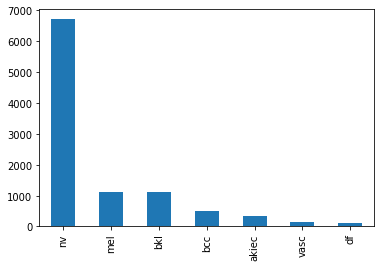

In [5]:
df['dx'].value_counts().plot(kind = 'bar')

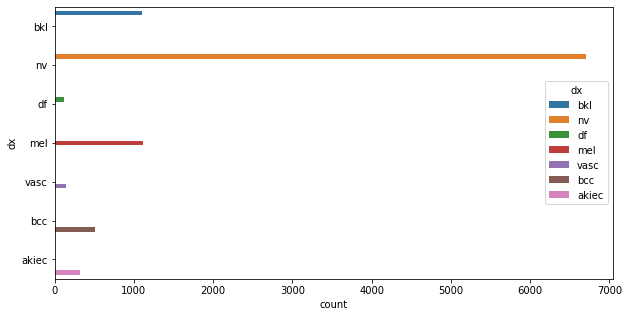

In [6]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
sns.countplot(y='dx',data=df, hue="dx",ax=ax1)

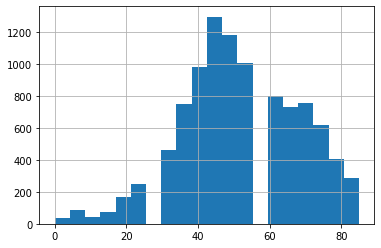

In [7]:
df['age'].hist(bins = 20)

Separate data frame in types of pigmented skin lessions

In [8]:
bkl = df[df.dx == 'bkl']
nv = df[df.dx == 'nv']
dermf =  df[df.dx == 'df']
mel = df[df.dx == 'mel']
vasc = df[df.dx == 'vasc']
bcc = df[df.dx == 'bcc']
akiec = df[df.dx == 'akiec']

### Test Set

We take 20% of the samples from the previous separation for test

In [9]:
test_bkl = bkl.sample(frac=0.2)
test_nv = nv.sample(frac=0.2)
test_dermf = dermf.sample(frac=0.2)
test_mel = mel.sample(frac=0.2)
test_vasc = vasc.sample(frac=0.2)
test_bcc = bcc.sample(frac=0.2)
test_akiec = akiec.sample(frac=0.2)

Create a test folder

In [ ]:
if not os.path.exists('/home/titus/fastai/SATAI/test'):
    os.mkdir('/home/titus/fastai/SATAI/test')

Fill the test folder with the previous division

In [18]:
to_append = [test_nv['image_id'], 
            test_dermf['image_id'],
            test_mel['image_id'],
            test_vasc['image_id'],
            test_bcc['image_id'],
            test_akiec['image_id']]
test_list = test_bkl['image_id'].append(to_append,ignore_index=True)
test_list.shape

(2003,)

Create a new data frame with the images of train and validation sets

In [19]:
df_trainval = df[~df['image_id'].isin(test_list)]
df_trainval.shape

(8012, 7)

Now that we have the 20% of the images for test in a single list we can move the images to a test folder

In [20]:
src_path = '/home/titus/fastai/SATAI/skin-cancer-mnist-ham10000/images'
dst_path = '/home/titus/fastai/SATAI/skin-cancer-mnist-ham10000/test'

for image in test_list:    
    fname = image + '.jpg'
    fname_path = os.path.join(src_path, fname)
    
    shutil.move(fname_path,dst_path)

We define the batch size and the size of the images

In [8]:
#bs = 64
bs = 32

size = 224

#### Transform

We dont want to change the images in excess since it could condition the results badly, if we apply warping os noise to the images they will be distorted and hence not valid for training (a regular lession could take an irregular shape).

In [36]:
tfms = get_transforms(do_flip=True,
                      # a random flip is applied with probability 0.5
                      flip_vert=True,
                      # the image can be flipped vertically or rotated by 90 degrees
                      max_lighting=0.1,
                      # a random lightning and contrast change controlled by max_lighting is applied
                      max_zoom=1.01, 
                      # a random zoom between 1. and max_zoom is applied
                      max_warp=0.
                      # we dont want warping since is clinical data that must not be distorted
                     )

### Data bunch

Since we already have separated the test images (2003) from the images folder, we need to split the validation set in order to get the same 20% of the original set, this is a 25% of the reamining images to get the same 2003 images for the validation set. The labels will be obtained from dx column in the data frame. 

In [37]:
src = (ImageList.from_df(df=df_trainval, path=path, cols=1, folder='images', suffix='.jpg')
       # the name of the images is defined by the column 1 'image_id'
       .split_by_rand_pct(0.25)
       # we get the 25% of the images in 'images' folder (2003 images)
       .label_from_df(cols='dx', label_cls=CategoryList))
       # we obtain the label from dx column, only one label could be applied to the image

Generate a data bunch from the previous division, applying the transformations previously defined in order to augment our data.

In [38]:
data = (src.transform(tfms, size=size)
        # apply the transforms defined in tfms
        .add_test_folder(test_folder='/home/titus/fastai/SATAI/skin-cancer-mnist-ham10000/test')
        # define the test folder
        .databunch().normalize(imagenet_stats))
        # create the data buch and normalize as imagenet
print('Transforms = ', len(tfms))
print(data.classes)
data

Transforms =  2
['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


ImageDataBunch;

Train: LabelList (6009 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bkl,bkl,bkl,bkl,bkl
Path: /home/titus/fastai/SATAI/skin-cancer-mnist-ham10000;

Valid: LabelList (2003 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
nv,nv,nv,bkl,mel
Path: /home/titus/fastai/SATAI/skin-cancer-mnist-ham10000;

Test: LabelList (2003 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /home/titus/fastai/SATAI/skin-cancer-mnist-ham10000

Save the Data Bunch so we don't have to generate it again

In [39]:
data.save('imageListDataBunch-bs-'+str(bs)+'-size-'+str(size)+'.pkl')

Load the Data Bunch previously saved if needed

In [12]:
data = load_data(path, 'imageListDataBunch-bs-'+str(bs)+'-size-'+str(size)+'.pkl')

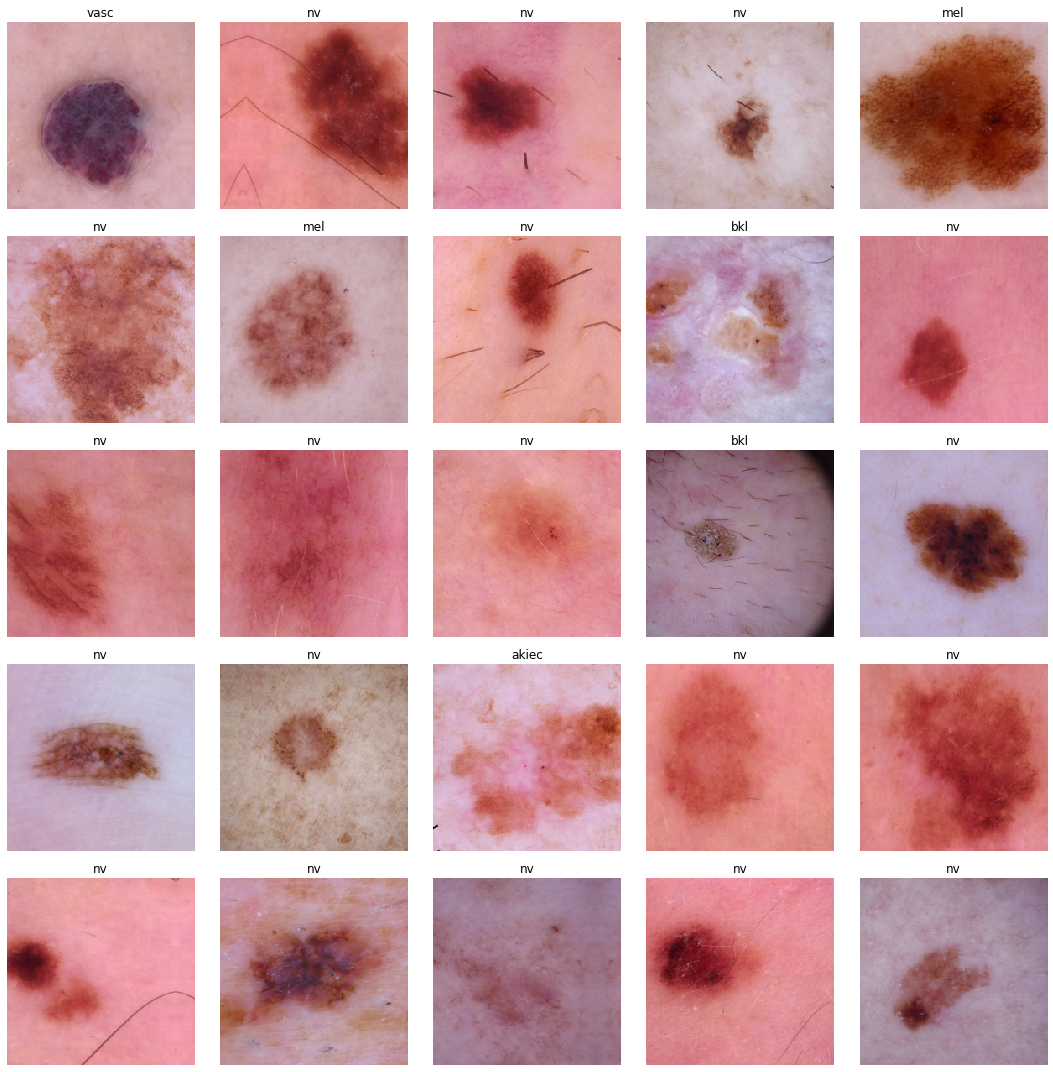

In [40]:
data.show_batch(rows=5, figsize=(15,15))


In [27]:
! /usr/bin/nvidia-smi

Wed Dec 11 00:16:23 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.64       Driver Version: 430.64       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 2070    Off  | 00000000:01:00.0  On |                  N/A |
| N/A   54C    P8     8W /  N/A |   1586MiB /  7982MiB |      3%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Training: ResNet34

Now we will start training our model using a convolutional neural network already trained as is ResNet34 taking as metrics the error rate, recall, precission, FBeta y MatthewsCorreff

In [26]:
f_score = partial(fbeta, thresh=0.2, beta = 1)

Create a learner based on ResNet34

In [57]:
learner = cnn_learner(
    data, 
    models.resnet34, 
    metrics=[error_rate, Recall(), Precision(), FBeta(), MatthewsCorreff()], 
    path=path/'models'
)

In [58]:
learner.loss_func

FlattenedLoss of CrossEntropyLoss()

In [59]:
defaults.device = torch.device('cuda')

To choose an appropiate learning rate we make use of lr_find

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-02
Min loss divided by 10: 1.45E-02


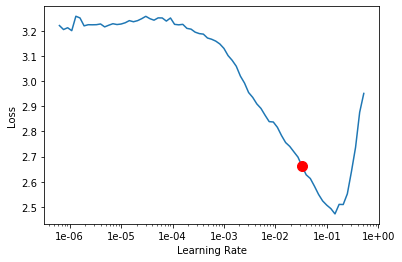

In [60]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

We choose a learning rate based on the previous graph's steepest slope.

In [61]:
lr=1e-2

epoch,train_loss,valid_loss,error_rate,recall,precision,f_beta,matthews_correff,time
0,1.690531,0.928635,0.264104,0.429400,0.516456,0.435497,0.486800,00:52
1,1.033510,0.724889,0.249126,0.420840,0.604700,0.448088,0.493427,00:51
2,0.836036,0.651794,0.225662,0.499049,0.636635,0.521594,0.540709,00:52
3,0.704751,0.658340,0.238143,0.474690,0.669062,0.503973,0.489152,00:53
4,0.632812,0.521971,0.193210,0.610758,0.697966,0.626411,0.609052,00:52
5,0.551321,0.496336,0.189715,0.599226,0.721167,0.620200,0.627925,00:53
6,0.508117,0.479629,0.182726,0.614433,0.682710,0.626974,0.636209,00:54
7,0.474844,0.472300,0.175736,0.622849,0.705344,0.637768,0.650789,00:53


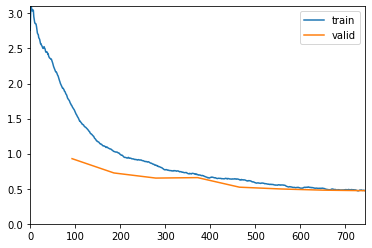

In [62]:
learner.fit_one_cycle(8, slice(lr),callbacks=ShowGraph(learner))
#learner.fit_one_cycle(8, max_lr=slice(2e-3, 6e-2),callbacks=ShowGraph(learner))

Save our learner so we don't need to process fit_one_cycle

In [65]:
learner.save('stage-1-rn34_lr1e-2', return_path=True)

PosixPath('/home/titus/fastai/SATAI/skin-cancer-mnist-ham10000/models/models/stage-1-rn34_lr1e-2.pth')

We export our model in case we want to load it on a web application

In [66]:
learner.export(file = Path('/home/titus/fastai/SATAI/trained_model_FAI.pkl'))

In case we need to load the model:

In [41]:
learner = load_learner(path=Path('/home/titus/fastai/SATAI'),file='trained_model_FAI.pkl')

To this point we only have trained the last layers, maintaining the model freezed, now we are going to unfreeze the model so we can train all the layers in it.

In [42]:
learner.unfreeze()

Again, we need to find the learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 1.91E-07


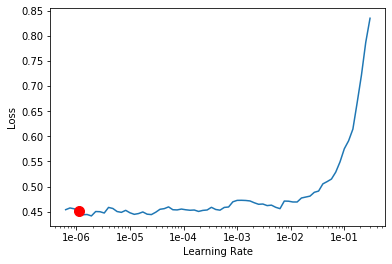

In [67]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

We need to choose a learning rate where the graphic tends to flatten and then choose a value 1/10 minor, as we can see 3e-4 seems to be a point when the graphic flattens, so we take 3e-5. For the second half of the slice we can take the learning rate used on the frozen part divided by 5 or 10

epoch,train_loss,valid_loss,error_rate,recall,precision,f_beta,matthews_correff,time
0,0.475822,0.475901,0.182227,0.612418,0.690464,0.623362,0.638610,00:47
1,0.477963,0.469036,0.173240,0.638309,0.729749,0.654716,0.654635,00:47
2,0.470657,0.461510,0.175736,0.638408,0.707202,0.651075,0.651681,00:47
3,0.444052,0.464135,0.177234,0.626626,0.704030,0.640715,0.647008,00:46
4,0.438028,0.458183,0.168248,0.659017,0.736040,0.673105,0.668810,00:46
5,0.438930,0.455913,0.166750,0.639302,0.733634,0.656177,0.664923,00:47
6,0.417793,0.447031,0.168248,0.652739,0.725339,0.666073,0.667178,00:48
7,0.417093,0.444309,0.162257,0.672612,0.726184,0.682685,0.681337,00:48
8,0.395940,0.444758,0.163754,0.643725,0.739011,0.660765,0.674220,00:47
9,0.396417,0.442712,0.163754,0.665580,0.731869,0.677860,0.675876,00:47


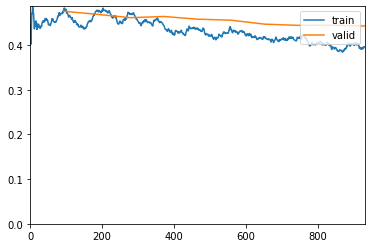

In [68]:
learner.fit_one_cycle(10, slice(3e-5,lr/10),callbacks=ShowGraph(learner))

We save this stage

In [69]:
learner.save('stage-2-rn34')

And export the model in a pickle format

In [70]:
learner.export(file = Path('/home/titus/fastai/SATAI/trained_model_unfrozen_FAI.pkl'))

If we want to load it and save the training we just run:

In [71]:
learn = load_learner(path=Path('/home/titus/fastai/SATAI'), file='trained_model_unfrozen_FAI.pkl')

### Confusion Matrix

In [72]:
interp = ClassificationInterpretation.from_learner(learner)

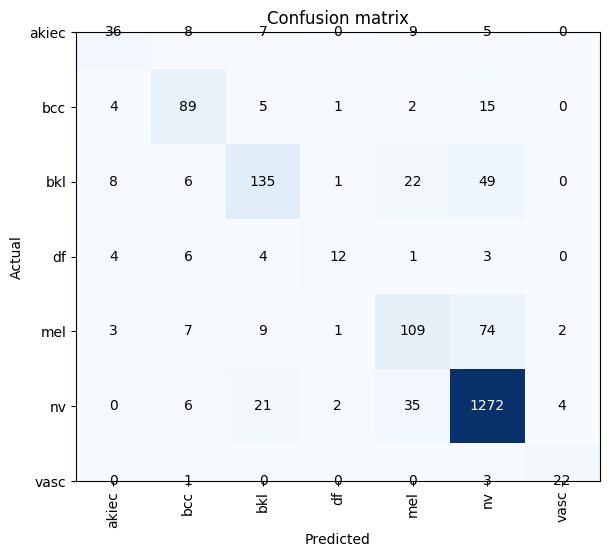

In [74]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=100)

In [75]:
interp.most_confused()

[('mel', 'nv', 74),
 ('bkl', 'nv', 49),
 ('nv', 'mel', 35),
 ('bkl', 'mel', 22),
 ('nv', 'bkl', 21),
 ('bcc', 'nv', 15),
 ('akiec', 'mel', 9),
 ('mel', 'bkl', 9),
 ('akiec', 'bcc', 8),
 ('bkl', 'akiec', 8),
 ('akiec', 'bkl', 7),
 ('mel', 'bcc', 7),
 ('bkl', 'bcc', 6),
 ('df', 'bcc', 6),
 ('nv', 'bcc', 6),
 ('akiec', 'nv', 5),
 ('bcc', 'bkl', 5),
 ('bcc', 'akiec', 4),
 ('df', 'akiec', 4),
 ('df', 'bkl', 4),
 ('nv', 'vasc', 4),
 ('df', 'nv', 3),
 ('mel', 'akiec', 3),
 ('vasc', 'nv', 3),
 ('bcc', 'mel', 2),
 ('mel', 'vasc', 2),
 ('nv', 'df', 2),
 ('bcc', 'df', 1),
 ('bkl', 'df', 1),
 ('df', 'mel', 1),
 ('mel', 'df', 1),
 ('vasc', 'bcc', 1)]

As we can see we still need to improve our model since we have so many error in identifying melanomas